# Fixed Effect vs Continuous Feature in Experiments
Julian Hsu
18-july-2023

The purpose of this script is to understand the implications of modeling the experimental variation as a fixed effect versus continuous feature. 

Consider an experiment where we randomly changed $w_i$ to be $w_1$ and $w_2$. We want to know calculating the standard error from two OLS regressions:
$$ Y_i = \beta_0 + \tau_1 1\{w_i = w_1\} + \tau_2 1\{w_i = w_2\} + \epsilon_i $$
$$ Y_i = \beta_0 + \alpha w_i + \eta_i $$
and then finding the point estimate and standard error from the average of $\hat{\tau}_1$ and $\hat{\tau}_2$ to that of $\hat{\alpha} (w_1 + w_2) / 2$.

**Sound byte**: There are precision benefits from making assumptions about your data. We often want to test more treatments than we feasibly deploy. *When you experiment with a low and high price change, can you infer how a medium price change would do?* I show below with simulated data that if you are willing to assume a linear relationship in price change, then your confidence interval is much smaller. The confidence interval is wider if you assume the two treatments' impacts are not related.

Assuming a relationship between the treatments means that you can link the results from your two experiments and use it to better predict the impacts of "counterfactual treatments." Of course, you *must consider* whether this assumption seems reasonable. The further apart the two treatments, the less likely there is a linear relationship.

I find the same if you want to extrapolate from your limited experiments too. Check it out here! (link)

In [89]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


## Write a function to generate data and estimate paramers
Assume completely random experiments

In [81]:
def dgp(N=1000, p=0.5, w1=1, w2=5):
    '''
    N       sample size
    p       probability of sample given w1 vs w2
    w1,w2   w1 and w2 values
    '''
    data_out = pd.DataFrame()
    data_out['w'] = w1 + (w2-w1)*np.random.choice(2, N, p=[1-p,p])
    data_out.loc[(np.random.choice(2,N,p=[1-p/2, p/2])==1), 'w']=0
    data_out['y'] = 2+ data_out['w'] + np.random.normal(0,1,N)
    data_out['w1'] = (data_out['w']==w1).astype(float)
    data_out['w2'] = (data_out['w']==w2).astype(float)
    return data_out

In [69]:
def ols_fe(data=None):
    ols_fe_model = sm.OLS(data['y'], sm.add_constant(data[['w1','w2']])).fit()
    return ols_fe_model

def ols_co(data=None):
    ols_co_model = sm.OLS(data['y'], sm.add_constant(data[['w']])).fit()
    return ols_co_model

In [70]:
df = dgp(w1=1, w2=5)

In [71]:
display( df['w'].value_counts() )
display(df.describe().T)


5    410
1    341
0    249
Name: w, dtype: int64

,count,mean,std,min,25%,50%,75%,max
w,1000.0,2.391000,2.208845,0.000000,1.000000,1.000000,5.000000,5.000000
y,1000.0,4.388412,2.248534,0.578192,2.456033,3.320946,6.829573,8.355892
w1,1000.0,0.341000,0.474283,0.000000,0.000000,0.000000,1.000000,1.000000
w2,1000.0,0.410000,0.492079,0.000000,0.000000,0.000000,1.000000,1.000000


## Now plot the standard error and estimates from interpolations and extrapolations

We will start with single use cases for a single dataset, and then do a lot of simulations.

**Interpolations**

In [72]:
print('GT values of w1={0} and w2={1}'.format(1,5))
fe_result = ols_fe(data=df)

fe_avg_coef = fe_result.params[['w1','w2']].mean()
fe_avg_se = np.sqrt( fe_result.cov_params()['w1']['w1']+fe_result.cov_params()['w2']['w2']+2*fe_result.cov_params()['w1']['w2'] )
print('Predicted interpolation point estimate and se: {0:3.2f} [{1:3.2f}]'.format(fe_avg_coef, fe_avg_se))

GT values of w1=1 and w2=5
Predicted interpolation point estimate and se: 3.02 [0.07]


In [73]:
print('GT values of w={0}'.format(1))
co_result = ols_co(data=df)

co_avg_coef = co_result.params['w']*3
co_avg_se =  co_result.bse['w']*(3**2)
print('Predicted interpolation point estimate and se: {0:3.2f} [{1:3.2f}]'.format(co_avg_coef, co_avg_se))


GT values of w=1
Predicted interpolation point estimate and se: 2.98 [0.06]


**Extrapolations**

In [76]:
fe_avg_coef = fe_result.params['w2']*1.5
fe_avg_se = fe_result.bse['w2']*(1.5**2)
print('Extrapolate to {0}'.format(5*1.5))
print('Predicted extrapolation point estimate and se: {0:3.2f} [{1:3.2f}]'.format(fe_avg_coef, fe_avg_se))

Extrapolate to 7.5
Predicted extrapolation point estimate and se: 7.49 [0.09]


In [77]:
co_avg_coef = co_result.params['w']*5*1.5
co_avg_se =  co_result.bse['w']*(5*1.5**2)
print('Extrapolate to {0}'.format(5*1.5))
print('Predicted interpolation point estimate and se: {0:3.2f} [{1:3.2f}]'.format(co_avg_coef, co_avg_se))


Extrapolate to 7.5
Predicted interpolation point estimate and se: 7.45 [0.08]


**Okay now run a lot of simulations and collect results**

In [ ]:
Srange=2000
df_result = pd.DataFrame()
for s_ in range(Srange):
    df = dgp(w1=1, w2=5)
    ## Train OLS models
    fe_result = ols_fe(data=df)
    co_result = ols_co(data=df)        
        
    ## Interpolations
    fe_avg_coefA = fe_result.params[['w1','w2']].mean()
    fe_avg_seA = np.sqrt( fe_result.cov_params()['w1']['w1']+fe_result.cov_params()['w2']['w2']+2*fe_result.cov_params()['w1']['w2'] )
    
    co_avg_coefA = co_result.params['w']*3
    co_avg_seA =  co_result.bse['w']*(3**2)

    ## Extrapolations
    fe_avg_coefB = fe_result.params['w2']*1.5
    fe_avg_seB = fe_result.bse['w2']*(1.5**2)

    co_avg_coefB = co_result.params['w']*5*1.5
    co_avg_seB =  co_result.bse['w']*(5*1.5**2)
    
    out = pd.DataFrame(index=[s_],
                        data={'inter_fe_coef':fe_avg_coefA, 'inter_fe_se':fe_avg_seA
                            ,'extra_fe_coef':fe_avg_coefB, 'extra_fe_se':fe_avg_seB
                            ,'inter_co_coef':co_avg_coefA, 'inter_co_se':co_avg_seA
                            ,'extra_co_coef':co_avg_coefB, 'extra_co_se':co_avg_seB})
    df_result=pd.concat([df_result, out])

In [130]:
for x in ['inter_fe_se','extra_fe_se','inter_co_se','extra_co_se']:
    df_result['cir_{0}'.format(x)] = 2*1.96*df_result[x]
df_result.describe()

,inter_fe_coef,inter_fe_se,extra_fe_coef,extra_fe_se,inter_co_coef,inter_co_se,extra_co_coef,extra_co_se,cir_inter_fe_se,cir_extra_fe_se,cir_inter_co_se,cir_extra_co_se
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,3.002356,0.146170,7.507125,0.183731,3.003158,0.131381,7.507896,0.164226,0.572987,0.720225,0.515014,0.643767
std,0.072924,0.004091,0.127099,0.004875,0.045729,0.003182,0.114322,0.003977,0.016037,0.019110,0.012473,0.015592
min,2.754131,0.132736,7.014202,0.166299,2.834165,0.120320,7.085412,0.150400,0.520326,0.651894,0.471656,0.589570
25%,2.950606,0.143384,7.419781,0.180643,2.970806,0.129328,7.427016,0.161661,0.562066,0.708119,0.506967,0.633709
50%,2.999551,0.146184,7.500945,0.183804,3.002144,0.131284,7.505360,0.164105,0.573041,0.720511,0.514633,0.643291
75%,3.047866,0.148975,7.593348,0.187033,3.035504,0.133538,7.588759,0.166923,0.583980,0.733170,0.523471,0.654338
max,3.277033,0.158352,8.036437,0.197618,3.181099,0.140784,7.952747,0.175979,0.620739,0.774662,0.551872,0.689840


In [133]:
def histogram_plot(inter_type='inter', custom_title=None):
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,3), sharey=True)
    for x in ['fe','co']:
        if x=='fe':
            desc = 'Fixed Effects'
        else:
            desc = 'Continuous'
        di3=ax[0].hist(df_result['{1}_{0}_coef'.format(x,inter_type)], label=desc, alpha=0.45)
        ax[1].hist(df_result['cir_{1}_{0}_se'.format(x,inter_type)], label=desc, alpha=0.45)
        ax[0].legend(title='Treatment Arms\n Modeled as')
        ax[1].legend(title='Treatment Arms\n Modeled as')
    ax[0].set_title('Distribution of Coefficients')    
    ax[1].set_title('Distribution of 95% Confidence Interval')    
    fig.suptitle(custom_title)
    fig.tight_layout(h_pad=2)
    plt.show()


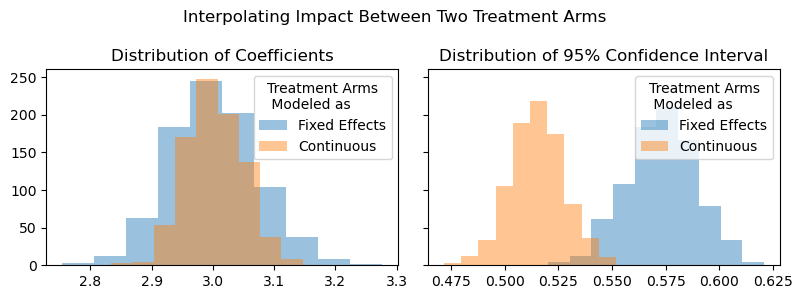

In [134]:
histogram_plot(inter_type='inter', custom_title='Interpolating Impact Between Two Treatment Arms')


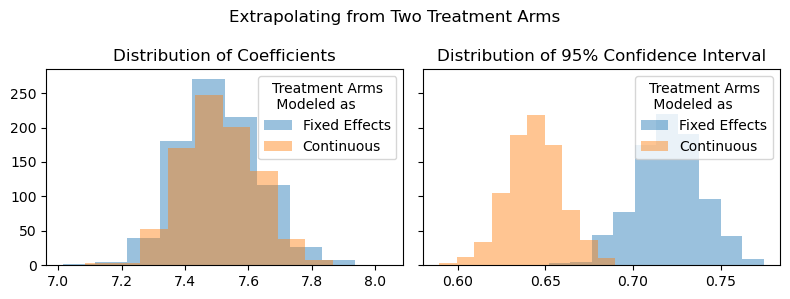

In [135]:
histogram_plot(inter_type='extra', custom_title='Extrapolating from Two Treatment Arms')